# Risk Forecasting with Extreme Value Theory

In [ ]:
!pip install arch
!pip install armagarch

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
from arch.univariate import arch_model
import armagarch as ag
from scipy.stats import shapiro
from scipy.stats import genpareto
from statsmodels.graphics.gofplots import qqplot
from scipy.optimize import minimize # For solving MLE maximisation numerically
from scipy.stats import kstest, anderson

## Question (i)

In [ ]:
file_path = '/QRM-2023-cw2-data.csv'
df = pd.read_csv(file_path)
df

,Date,TSLA
0,11/26/2012,2.151333
1,11/27/2012,2.143333
2,11/28/2012,2.215333
3,11/29/2012,2.246000
4,11/30/2012,2.254667
...,...,...
2514,11/18/2022,180.190002
2515,11/21/2022,167.869995
2516,11/22/2022,169.910004
2517,11/23/2022,183.199997


In [ ]:
df['simplereturn'] = df['TSLA'].pct_change()
df['logreturn'] = np.log(1 + df['simplereturn'])
# Multiply the return values by 100 so they represent percentage values
df['logreturn'] = df['logreturn'] * 100
df_train = df[:2267]
df_test = df[2267:]
df_test.reset_index(inplace=True, drop=True)
df.head()

,Date,TSLA,simplereturn,logreturn
0,11/26/2012,2.151333,NaN,NaN
1,11/27/2012,2.143333,-0.003719,-0.372556
2,11/28/2012,2.215333,0.033593,3.304064
3,11/29/2012,2.246000,0.013843,1.374813
4,11/30/2012,2.254667,0.003859,0.385143


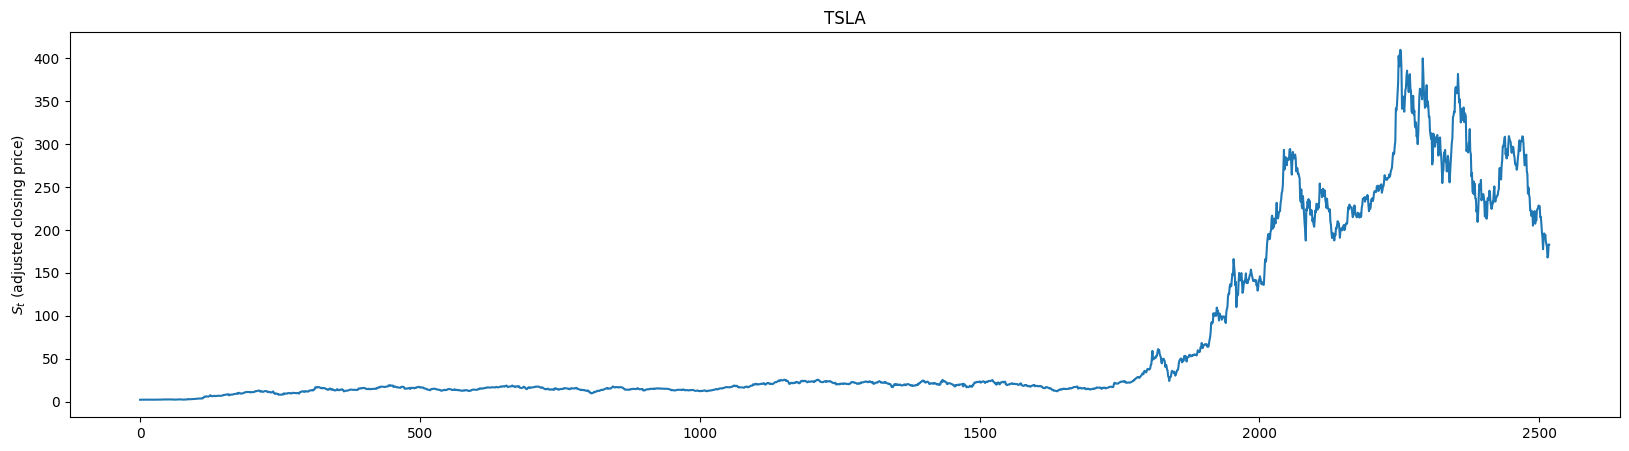

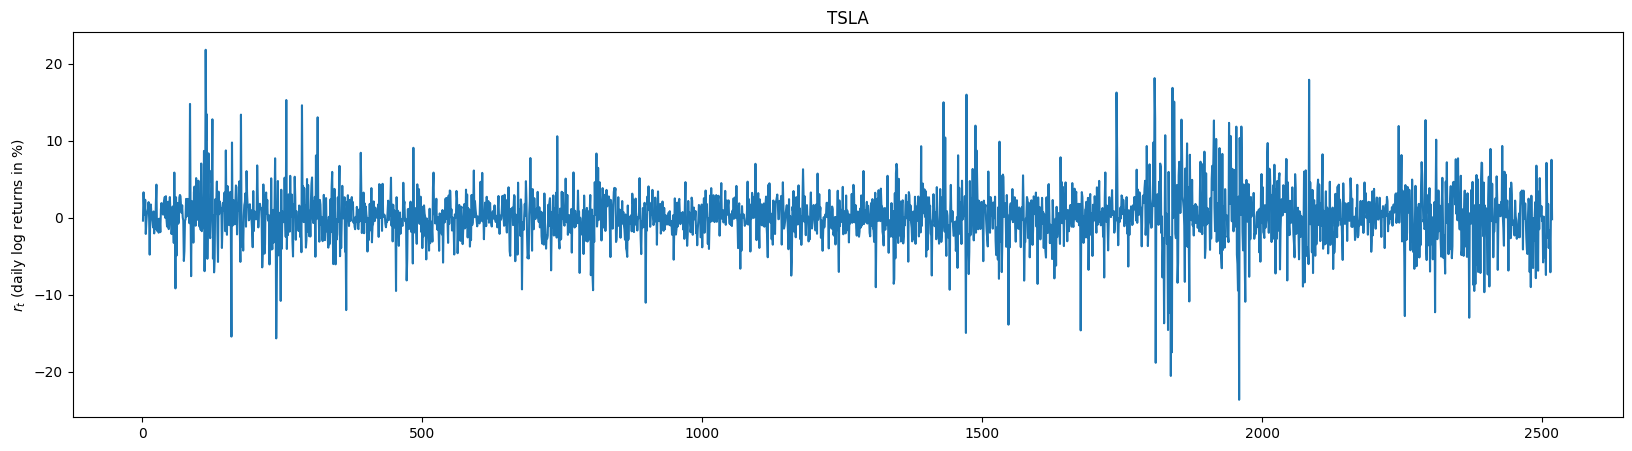

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df['TSLA'])
plt.ylabel(r"$S_t$ (adjusted closing price)")
plt.gcf().set_facecolor("white")
plt.title(r"TSLA")
plt.show()

plt.figure(figsize=(20,5))
plt.plot(df['logreturn'])
plt.ylabel(r"$r_t$ (daily log returns in %)")
plt.gcf().set_facecolor("white")
plt.title(r"TSLA")
plt.show()

In [ ]:
# Create the model object:
# p,q refer to the order of GARCH(p,q) model
# "mean=zero" refers to no ARMA component
# "dist=normal"  refers to N(0,1) distribution of the white noise process Z
model = arch_model(df_train['logreturn'][1:], vol='Garch', mean='Constant', p=1, q=1, dist='normal')

# Fit the model. Update_freq is a cosmetic parameter controlling how frequently the numerical iteration progress is reported on screen
res = model.fit()

# Show the fitting results
print(res)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.20172635719
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948234699395
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970863355942
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.872024036774
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501555668427
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248073390374
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.799770551253
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.3462608882055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.90925440826
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119613552
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.9091189004475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.9091189004475
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations:

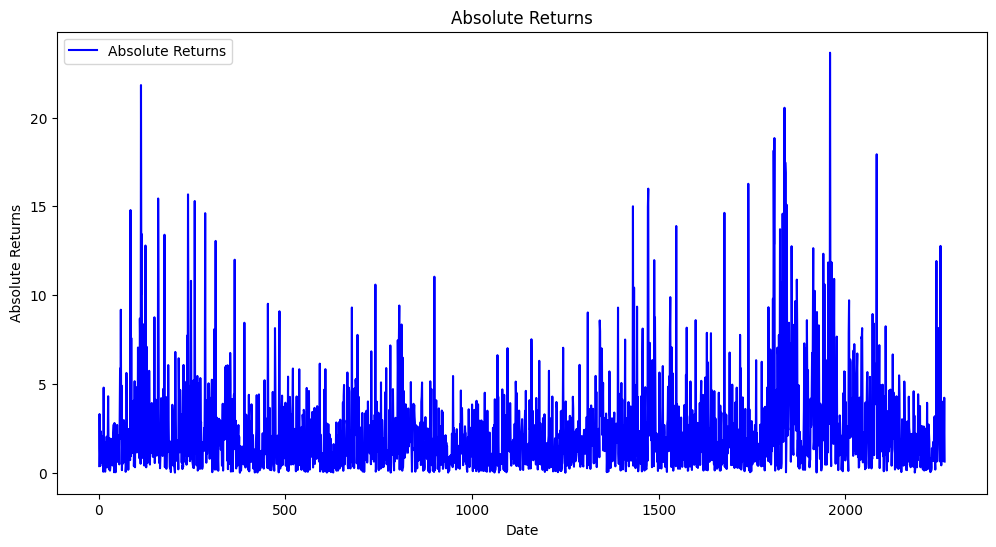

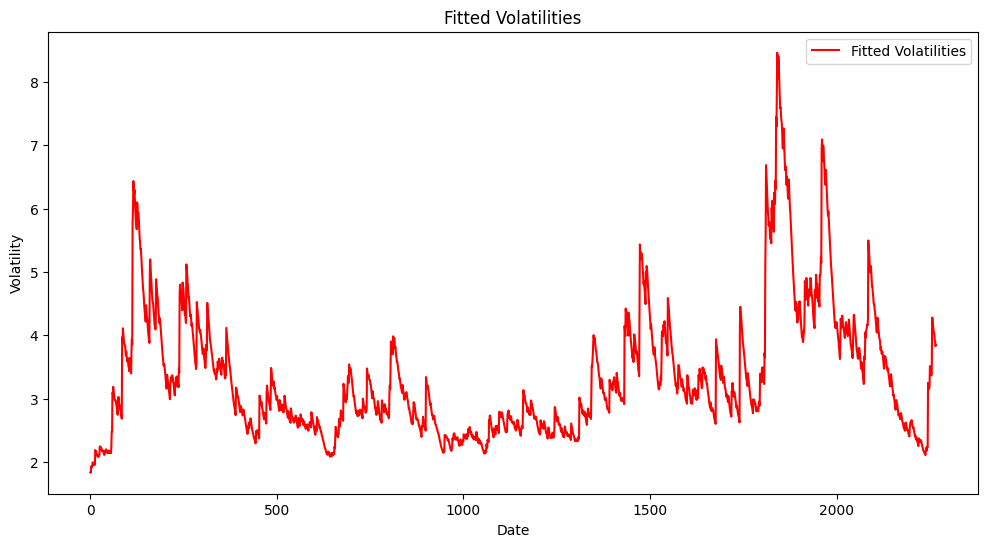

In [ ]:
# Plot absolute returns
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[1:], df_train['logreturn'][1:].abs(), label='Absolute Returns', color='blue')
plt.title('Absolute Returns')
plt.xlabel('Date')
plt.ylabel('Absolute Returns')
plt.legend()
plt.show()

# Plot fitted volatilities
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[1:], res.conditional_volatility, label='Fitted Volatilities', color='red')
plt.title('Fitted Volatilities')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

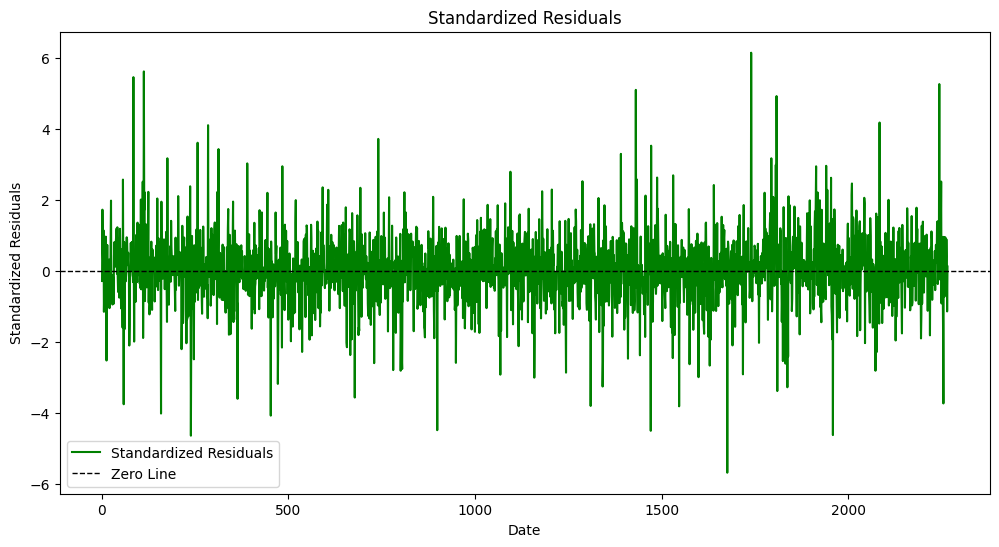

In [ ]:
# Get the standardized residuals
std_resid = res.resid / res.conditional_volatility

# Plot the standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[1:], std_resid, label='Standardized Residuals', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Standardized Residuals')
plt.xlabel('Date')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.show()

In [ ]:
# Perform Shapiro-Wilk test on standardized residuals
statistic, p_value = shapiro(std_resid)

# Print the test statistic and p-value
print(f'Shapiro-Wilk Test Statistic: {statistic}')
print(f'P-value: {p_value}')

# Check the null hypothesis
alpha = 0.05
if p_value > alpha:
    print('The standardized residuals appear to be normally distributed (fail to reject the null hypothesis).')
else:
    print('The standardized residuals do not appear to be normally distributed (reject the null hypothesis).')

Shapiro-Wilk Test Statistic: 0.9476943016052246
P-value: 1.1435302452401516e-27
The standardized residuals do not appear to be normally distributed (reject the null hypothesis).


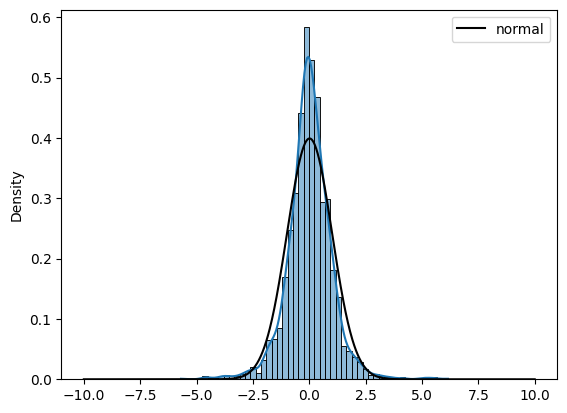

In [ ]:
x = np.linspace(-10,10,1000)
mu = std_resid.mean()
sigma = std_resid.std()

# Add the plot of N(\mu,\sigma) pdf on top of the seaborn histogram
sns_ax = sns.histplot(data=std_resid, bins=50, stat="density", kde=True)
sns_ax.plot(x,norm.pdf(x,mu,sigma),label="normal", color= "black")
plt.legend()

## Question (ii)

In [ ]:
import scipy.stats as stats

# Fit a Student's t-distribution to the standardized residuals
freedom, loc, scale = stats.t.fit(std_resid)

# Display the estimated parameters
print("Estimated Degrees of Freedom:", freedom)
print("Estimated Location Parameter:", loc)
print("Estimated Scale Parameter:", scale)

Estimated Degrees of Freedom: 3.560312705457344
Estimated Location Parameter: 0.014177589651393326
Estimated Scale Parameter: 0.6858956727869847


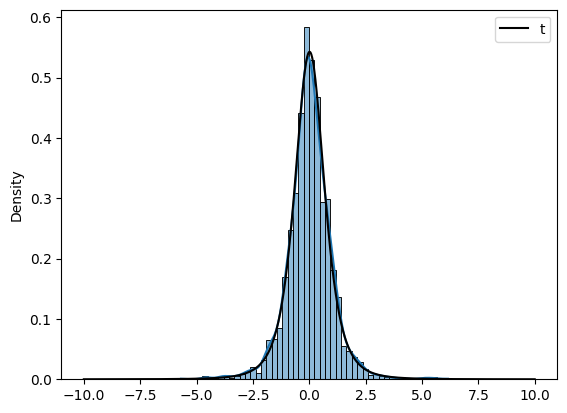

In [ ]:
from scipy.stats import t
x = np.linspace(-10,10,1000)

# Add the plot of N(\mu,\sigma) pdf on top of the seaborn histogram
sns_ax = sns.histplot(data=std_resid, bins=50, stat="density", kde=True)
sns_ax.plot(x,t.pdf(x,freedom, loc,scale),label="t", color='black')
plt.legend()

In [ ]:
# Test the goodness of fit using the Kolmogorov-Smirnov test
ks_statistic, ks_p_value = stats.kstest(std_resid, 't', args=(freedom, loc, scale))

# Display the results
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("P-value:", ks_p_value)

Kolmogorov-Smirnov Statistic: 0.016309361951697632
P-value: 0.577265762522674


If the p-value from the goodness-of-fit test is greater than a chosen significance level (e.g., 0.05), you may conclude that the distribution fits the data well.

## Question (iii)

Now, let's take a look at the sample (empirical) mean excess function which is defined via
\begin{align}
e_n(v):=\frac{\sum_{i=1}^n (X_i-v) 1_{(X_i> v)}}{\sum_{i=1}^n 1_{(X_i>v)}}.
\end{align}

Based on the observed fire claim data $(X_i)_{i=1,...,n}$, we can compute $e_n(v)$ for different cut-off threshold $v$.

[-5.69012093 -4.64585827 -4.62827961 ...  5.46199223  5.62308611
  6.15036296]


<ipython-input-415-90044032ff9c>:13: RuntimeWarning: invalid value encountered in double_scalars
  excess_mean.append(np.sum((std_resid - vv) * (std_resid > vv)) / np.sum(std_resid > vv))


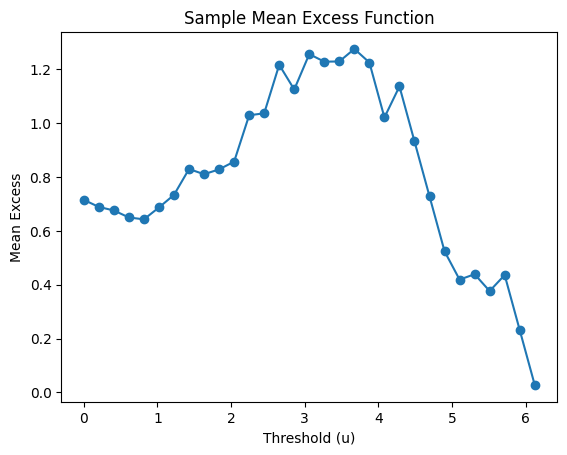

In [ ]:
# Choose a threshold 'u' based on the sample mean excess function plot
# This could involve visual inspection or using statistical criteria
# For demonstration purposes, you can plot the sample mean excess function

# Example: Assuming 'std_resid' is your standardized residuals
std_resid = np.sort(std_resid)
print(std_resid)
v = np.linspace(0, 10, 50) # Choose a range of threshold values
excess_mean = []

# Calculate mean excess for each threshold
for vv in v:
    excess_mean.append(np.sum((std_resid - vv) * (std_resid > vv)) / np.sum(std_resid > vv))

# Plot the mean excess function
plt.plot(v, excess_mean, 'r*')
plt.title("Sample mean excess function")
plt.ylabel("$e_n(v)$")
plt.xlabel("$v$")

plt.plot(v, excess_mean, marker='o')
plt.title('Sample Mean Excess Function')
plt.xlabel('Threshold (u)')
plt.ylabel('Mean Excess')
plt.show()

In the practical estimation of the threshold exceedance distribution, the threshold value $u$ can be chosen such that the graph of $e_{n}(v)$ displays a
`linear' trend when $v\geq u$. In what follows, we will select $u=2.7$.

The excess distribution is defined as $$F_u(x) := \mathbb{P}[X −u \leq x|X > u] .$$

For large $u$, we know that for a wide class of random variables, its excess distribution $F_u(x)$ can be well-approximated by a generalised Pareto distribution (GPD) in form of
\begin{equation*}
G_{\xi,\beta}(x) = \begin{cases}
1-(1+\xi x/ \beta)^{-1/ \xi},& \xi \neq 0,\\
1- \exp(-x/ \beta), & \xi = 0,
\end{cases}
\end{equation*}
where we require $x \geq 0$ when $\xi \geq 0$ and $0 \leq x \leq -\beta/ \xi$ when $\xi < 0$. The parameter $\beta$ will depend on $u$.

We can estimate the unknown parameters $\xi$ and $\beta$ in $G_{\xi,\beta}$ based on the available data by MLE.

To proceed, we first construct the "sample excess value above $u$" from the data. From the original fire claim data $X_1,X_2,...,X_n$, we extract a subset of them with claim value above $u$ and let's relabel this subset as $\tilde{X}_1,\tilde{X}_2,...,\tilde{X}_{N_u}$ where $N_u$ is a random number representing the number of claims above $u$. Then define  $$Y_i=\tilde{X}_i-u$$ for $i=1,2,...,N_u$.

We construct $Y$ as follows, which will contain 109 observations only.

In [ ]:
# Choose an appropriate threshold based on the plot
# In practice, you might choose a threshold where the mean excess stabilizes
u = 3.1 # our choice of u
y = std_resid[std_resid>u] - u # construction of y
print(y)

[0.07398196 0.0740586  0.19902489 0.33351971 0.42922853 0.51279303
 0.62068869 1.00703429 1.08235243 1.82769388 2.0031725  2.16669945
 2.36199223 2.52308611 3.05036296]


Next, we use $(Y_i)_{i=1,...,N_u}$ as the available observations to estimate $(\xi,\beta)$ by the method of MLE. Using the density function of $G_{\xi,\beta}$, we implement the log-likelihood function,
\begin{equation*}
\begin{split}
\log L(\xi,\beta; Y_1,\ldots, Y_{N_u}) & = \sum_{j=1}^{N_u} \log g_{\xi,\beta}(Y_j) \\
& = - N_u \log \beta - \bigg(1+ \frac{1}{\xi}\bigg) \sum_{j=1}^{N_u} \log \bigg(1+\xi \frac{Y_j}{\beta}\bigg),
\end{split}
\end{equation*}


In [ ]:
def GPD_loglikelihood(y, xi, beta):
    return -len(y) * np.log(beta) - (1 + 1/xi) * np.sum(np.log(1 + xi * y / beta))

We are now ready to numerically estimate $(\xi,\beta)$ by maximising $\log L(\xi,\beta;Y_1,...,Y_{N_u})$. This is done via the Scipy function "minimize".

In [ ]:
objfun = lambda theta : -1 * GPD_loglikelihood(y, theta[0], theta[1]) # theta[0] represents xi and theta[1] represents beta

theta0 = [1, 1]  # initial guess
print("Initial objective function value: " + str(objfun(theta0)))

bnds = ((0.01,20), (0,20)) # individual bound on each parameter

sol = minimize(objfun,theta0,method='SLSQP',bounds=bnds, options={'disp': True})

print("Estimate of xi: " + str(sol.x[0]))
print("Estimate of beta: " + str(sol.x[1]))

Initial objective function value: 20.917492760099016
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17.98164007823857
            Iterations: 8
            Function evaluations: 25
            Gradient evaluations: 8
Estimate of xi: 0.01
Estimate of beta: 1.2099844163525872


In principle, we shall allow $\xi$ to be any value in $\mathbb{R}$. But it is somewhat clear from the dataset that we expect $\xi>0$. To improve numerical stablility of the optimisation, in the implementation above we restrict $\xi$ (and $\beta$) to some arbitrarily and reasonably chosen range.

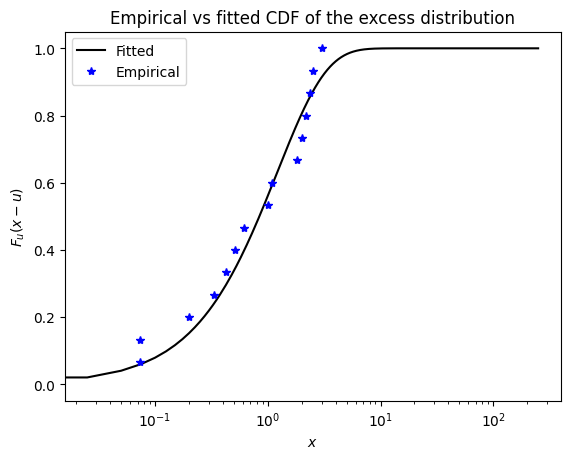

In [ ]:
def GPD_cdf(x, xi, beta): # Implement the CDF of GPD
    if xi == 0:
        return 1 - np.exp(-x/beta)
    else:
        return 1 - (1 + xi * x / beta) ** (-1/xi)

xx = np.linspace(0, 250, 10000) # For plotting the theoretical, fitted GPD

# Empirical CDF functionality from the "statsmodels" package
empirical_cdf_obj = sm.distributions.empirical_distribution.ECDF((y).flatten())

fig, ax = plt.subplots()
ax.plot(xx, GPD_cdf(xx, sol.x[0], sol.x[1]), 'k-', label='Fitted') # Plot the CDF of fitted GPD
ax.plot(y, empirical_cdf_obj(y), 'b*', label='Empirical') # Plot the empirical CDF of Y, the excess claim value above u
ax.legend()
ax.set_xscale('log')
ax.set_title('Empirical vs fitted CDF of the excess distribution')
ax.set_ylabel('$F_{u}(x-u)$')
ax.set_xlabel('$x$')
plt.show()

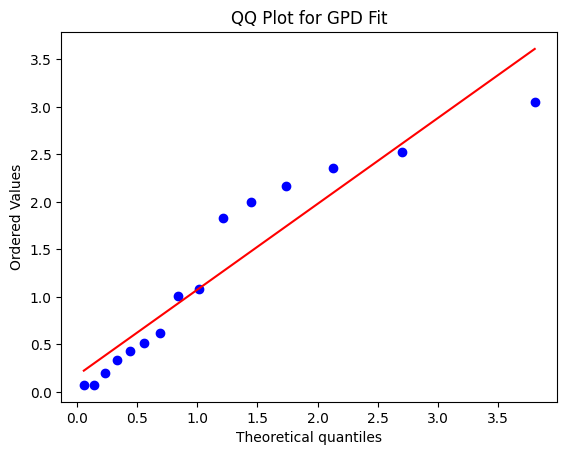

In [ ]:
from scipy.stats import genpareto, probplot
# Assess the quality of fit using a QQ plot
# Extract estimated parameters from the optimization result
xi_estimate = sol.x[0]
beta_estimate = sol.x[1]

# Define the generalized Pareto distribution using the estimated parameters
gpd_distribution = genpareto(xi_estimate, loc=0, scale=beta_estimate)

# Generate QQ plot using the estimated GPD distribution
probplot(y, dist=gpd_distribution, plot=plt)
plt.title('QQ Plot for GPD Fit')
plt.show()


Fitting a Generalized Pareto Distribution (GPD) to the tail of the standardized residuals involves selecting a threshold value
�
u based on the sample mean excess function plot. The mean excess plot helps to visualize the tail behavior of the data and choose an appropriate threshold.

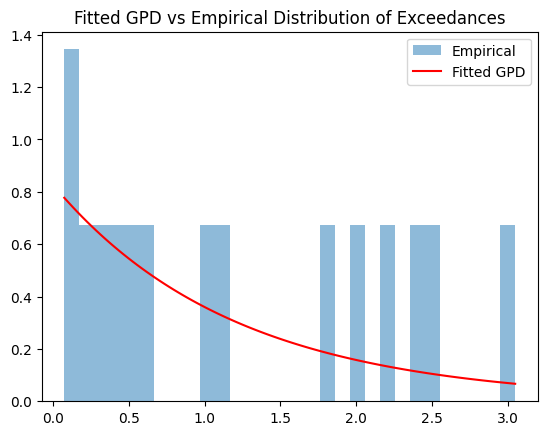

In [ ]:
# Fit the GPD distribution using the estimated parameters
x = np.linspace(min(y), max(y), 100)
fitted_gpd = genpareto.pdf(x, xi_estimate, loc=0, scale=beta_estimate)

# Plot the empirical histogram
plt.hist(y, bins=30, density=True, alpha=0.5, label='Empirical')

# Plot the fitted GPD distribution
plt.plot(x, fitted_gpd, 'r-', label='Fitted GPD')

plt.title('Fitted GPD vs Empirical Distribution of Exceedances')
plt.legend()
plt.show()

In [ ]:
# Kolmogorov-Smirnov Test
ks_statistic, ks_p_value = kstest(y, 'genpareto', args=(xi_estimate, 0, beta_estimate))
print("Kolmogorov-Smirnov Statistic:", ks_statistic)
print("Kolmogorov P-value:", ks_p_value)

# Anderson-Darling Test (using the Kolmogorov-Smirnov test)
ad_statistic, ad_p_value = kstest(y, 'genpareto', args=(xi_estimate, 0, beta_estimate), alternative='greater')
print("Anderson-Darling Statistic:", ad_statistic)
print("Anderson P-value:", ad_p_value)

Kolmogorov-Smirnov Statistic: 0.17669475966555748
Kolmogorov P-value: 0.6737923211818138
Anderson-Darling Statistic: 0.08293146693092157
Anderson P-value: 0.7719472432218842


*Kolmogorov*-Smirnov Statistic (ks_statistic): This statistic measures the maximum vertical deviation between the empirical cumulative distribution function (ECDF) of the data and the theoretical GPD distribution. A higher statistic suggests a poorer fit.

P-value (ks_p_value): This indicates the probability of observing a Kolmogorov-Smirnov statistic as extreme as the one computed from the sample. A small p-value (typically less than 0.05) suggests rejecting the null hypothesis that the data follows the specified distribution.

Anderson-Darling Statistic (ad_statistic): Similar to the Kolmogorov-Smirnov statistic, the Anderson-Darling statistic measures the discrepancy between the empirical and theoretical distributions. A higher statistic indicates a poorer fit.

P-value (ad_p_value): This is the probability of observing an Anderson-Darling statistic as extreme as the one computed from the sample. As with the Kolmogorov-Smirnov test, a small p-value suggests rejecting the null hypothesis.

If both the Kolmogorov-Smirnov and Anderson-Darling tests have high p-values (greater than 0.05), you might conclude that there is no significant difference between the empirical data and the GPD fit.

## Question (iv)

### a) Standard Normal Distribution

VaR and ES Calculation for Standard Normal Distribution (i.e., Gaussian Distribution):

**VaR Calculation:**
For a standard normal distribution, VaR at a confidence level \( \alpha \) is given by the formula:
\[ \text{VaR}_{\alpha} = \text{mean} + \text{standard deviation} \times \text{inverse of standard normal cumulative distribution function at } (1 - \alpha) \]

**ES Calculation:**
Expected Shortfall (ES) at a confidence level \( \alpha \) is calculated as the average of the tail distribution beyond VaR:
\[ \text{ES}_{\alpha} = \text{mean} + \frac{\text{standard deviation}}{\sqrt{2\pi}} \times \exp\left(-\frac{\text{VaR}_{\alpha}^2}{2}\right) \div (1 - \alpha) \]



In [ ]:
model = arch_model(df_train['logreturn'][1:], vol='Garch', mean='constant',p=1,q=1,dist='normal')
result=model.fit()

sigma_0=df_train['logreturn'][1:].std()
print(sigma_0)
mu=result.params.iloc[0]
print(mu)
alpha_0=result.params.iloc[1]
print(alpha_0)
alpha_1=result.params.iloc[2]
print(alpha_1)
beta_1=result.params.iloc[3]
print(beta_1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 109978.20172635719
Iteration:      2,   Func. Count:     14,   Neg. LLF: 7646.948234699395
Iteration:      3,   Func. Count:     20,   Neg. LLF: 5878.970863355942
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5902.872024036774
Iteration:      5,   Func. Count:     32,   Neg. LLF: 5882.501555668427
Iteration:      6,   Func. Count:     38,   Neg. LLF: 5864.248073390374
Iteration:      7,   Func. Count:     44,   Neg. LLF: 5926.799770551253
Iteration:      8,   Func. Count:     51,   Neg. LLF: 5896.3462608882055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 5854.90925440826
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5854.909119613552
Iteration:     11,   Func. Count:     67,   Neg. LLF: 5854.9091189004475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5854.9091189004475
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations:

<ipython-input-424-b55dcc9015c7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[0,'sigma']=sigma_0
<ipython-input-424-b55dcc9015c7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[i,'VaR_95']=mu+df_test.loc[i,'sigma']*q95
<ipython-input-424-b55dcc9015c7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

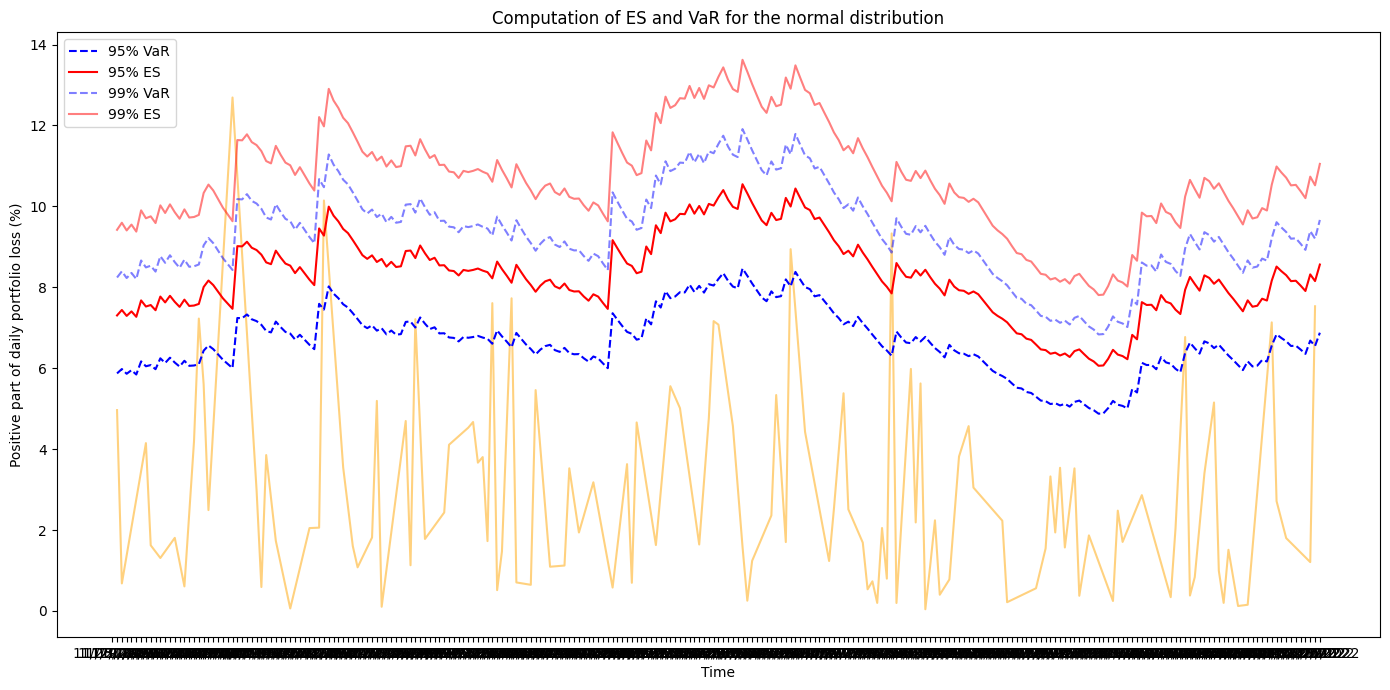

In [ ]:
q95 = norm.ppf(0.95)
q99 = norm.ppf(0.99)

D = norm(0,1)
test = D.rvs(size = 100000)
ES_95= np.mean(test[test>=q95])
ES_99= np.mean(test[test>=q99])


df_test.loc[0,'sigma']=sigma_0
for i in range(1,len(df_test)):
    df_test.loc[i,'sigma']=np.sqrt(alpha_0+alpha_1*(df_test.loc[i-1,'logreturn']-mu)**2+beta_1*df_test.loc[i-1,'sigma']**2)
    df_test.loc[i,'VaR_95']=mu+df_test.loc[i,'sigma']*q95
    df_test.loc[i,'VaR_99']=mu+df_test.loc[i,'sigma']*q99
    df_test.loc[i,'ES_95']=mu+df_test.loc[i,'sigma']*ES_95
    df_test.loc[i,'ES_99']=mu+df_test.loc[i,'sigma']*ES_99

def positive_loss(df_results):
    condition_loss = df_results['logreturn'] >= 0
    return (df_results.loc[condition_loss, 'logreturn'])



# Plotting
plt.figure(figsize=(14, 7))

# Actual positive losses
plt.plot(positive_loss(df_test), color='orange', alpha=0.5)

# HS VaR and ES for 95% confidence level
plt.plot(df_test['Date'], df_test.VaR_95, label='95% VaR', linestyle='--', color='blue')
plt.plot(df_test['Date'], df_test.ES_95, label='95% ES', color='red')

# HS VaR and ES for 99% confidence level
plt.plot(df_test['Date'], df_test.VaR_99, label='99% VaR', linestyle='--', color='blue', alpha=0.5)
plt.plot(df_test['Date'], df_test.ES_99, label='99% ES', color='red', alpha=0.5)

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Positive part of daily portfolio loss (%)')
plt.title('Computation of ES and VaR for the normal distribution')
plt.legend(loc='upper left')

# Turn off the grid
plt.grid(False)

plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [ ]:
len(df_test.loc[df_test.logreturn>df_test.VaR_95])/len(df_test)*100
len(df_test.loc[df_test.logreturn>df_test.VaR_99])/len(df_test)*100

0.7936507936507936

In [ ]:
def pi_estimator(data_bis:pd.DataFrame, alpha:float):
    data = data_bis.dropna()
    if alpha==0.95:
        return len(data.loc[data.logreturn>data.VaR_95])/len(data)
    elif alpha==0.99:
        return len(data.loc[data.logreturn>data.VaR_99])/len(data)

In [ ]:
from scipy.stats import chi2
def LRUC(data_bis:pd.DataFrame, alpha:float):
    data = data_bis.dropna()
    data.reset_index(inplace=True,drop=True)
    pi = pi_estimator(data,alpha)
    if alpha ==0.95:
        n=len(data.loc[data.logreturn > data.VaR_95])
    else:
        n=len(data.loc[data.logreturn > data.VaR_99])
    print('nb violations :',n)
    return -2*n*np.log((1-alpha)/pi) - 2 * (len(data)-n) * np.log(alpha/(1-pi))


def p_value_LRUC(data:pd.DataFrame, alpha:float):
    return 1-chi2.cdf(LRUC(data, alpha),1)

In [ ]:
print(p_value_LRUC(df_test,0.95))
print(p_value_LRUC(df_test,0.99))

nb violations : 11
0.6468496471131203
nb violations : 2
0.7373114985717468


### b) Normalised Student t distribution

VaR and ES Calculation for Normalized Student t Distribution:

**VaR Calculation:**
Use the quantile function of the Student's t distribution with appropriate degrees of freedom.

**ES Calculation:**
Similar to the standard normal distribution, calculate ES using the tail distribution beyond VaR.

In [ ]:
model = arch_model(df_train['logreturn'][1:], vol='Garch', mean='constant',p=1,q=1,dist='t')
result=model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 50187.39276251274
Iteration:      2,   Func. Count:     15,   Neg. LLF: 58998.02050466141
Iteration:      3,   Func. Count:     24,   Neg. LLF: 9431.707953537325
Iteration:      4,   Func. Count:     33,   Neg. LLF: 7222.205272141231
Iteration:      5,   Func. Count:     40,   Neg. LLF: 6375.35164544603
Iteration:      6,   Func. Count:     47,   Neg. LLF: 7406.897179834148
Iteration:      7,   Func. Count:     54,   Neg. LLF: 5681.164285896496
Iteration:      8,   Func. Count:     61,   Neg. LLF: 5678.136991189916
Iteration:      9,   Func. Count:     68,   Neg. LLF: 7216.318934059493
Iteration:     10,   Func. Count:     75,   Neg. LLF: 5673.941248328631
Iteration:     11,   Func. Count:     81,   Neg. LLF: 5673.90041866109
Iteration:     12,   Func. Count:     87,   Neg. LLF: 5673.898057731587
Iteration:     13,   Func. Count:     93,   Neg. LLF: 5673.8979292997765
Iteration:     14,   Func. Count:     99,   Neg. LLF: 5673.897906

In [ ]:
mu_student=result.params.iloc[0]
alpha_0_student=result.params.iloc[1]
alpha_1_student=result.params.iloc[2]
beta_1_student=result.params.iloc[3]
print(mu_student)
print(alpha_0_student)
print(alpha_1_student)
print(beta_1_student)

0.18589732421422475
0.14355693057916968
0.04204278863367867
0.9502890439651243


In [ ]:
#Determined above
print('Freedom :',freedom)
print('Loc :',loc)
print('Scale :',scale)

Freedom : 3.560312705457344
Loc : 0.014177589651393326
Scale : 0.6858956727869847


In [ ]:
q95 = t.ppf(0.95,df=freedom,loc=loc,scale=scale)
q99 = t.ppf(0.99,df=freedom,loc=loc,scale=scale)


D = t(df=freedom,loc=loc,scale=scale)
test = D.rvs(size = 100000)
ES_95= np.mean(test[test>=q95])
ES_99= np.mean(test[test>=q99])


df_test.loc[0,'sigma_student']=df_train.logreturn.std()
for i in range(1,len(df_test)):
    df_test.loc[i,'sigma_student']=np.sqrt(alpha_0_student+alpha_1_student*(df_test.loc[i-1,'logreturn']-mu)**2+beta_1_student*df_test.loc[i-1,'sigma_student']**2)
    df_test.loc[i,'VaR_95_student']=mu+df_test.loc[i,'sigma_student']*q95
    df_test.loc[i,'VaR_99_student']=mu+df_test.loc[i,'sigma_student']*q99
    df_test.loc[i,'ES_95_student']=mu+df_test.loc[i,'sigma']*ES_95
    df_test.loc[i,'ES_99_student']=mu+df_test.loc[i,'sigma']*ES_99

<ipython-input-432-d6c2069ec7b7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[0,'sigma_student']=df_train.logreturn.std()
<ipython-input-432-d6c2069ec7b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[i,'VaR_95_student']=mu+df_test.loc[i,'sigma_student']*q95
<ipython-input-432-d6c2069ec7b7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [ ]:
def pi_estimator_student(data_bis:pd.DataFrame, alpha:float):
    data = data_bis.dropna()
    if alpha==0.95:
        return len(data.loc[data.logreturn>data.VaR_95_student])/len(data)
    elif alpha==0.99:
        return len(data.loc[data.logreturn>data.VaR_99_student])/len(data)

def LRUC_student(data_bis:pd.DataFrame, alpha:float):
    data = data_bis.dropna()
    data.reset_index(inplace=True,drop=True)
    pi = pi_estimator_student(data,alpha)
    if alpha ==0.95:
        n=len(data.loc[data.logreturn > data.VaR_95_student])
    else:
        n=len(data.loc[data.logreturn > data.VaR_99_student])
    print('nb violations :',n)
    return -2*n*np.log((1-alpha)/pi) - 2 * (len(data)-n) * np.log(alpha/(1-pi))


def p_value_LRUC_student(data:pd.DataFrame, alpha:float):
    return 1-chi2.cdf(LRUC_student(data, alpha),1)

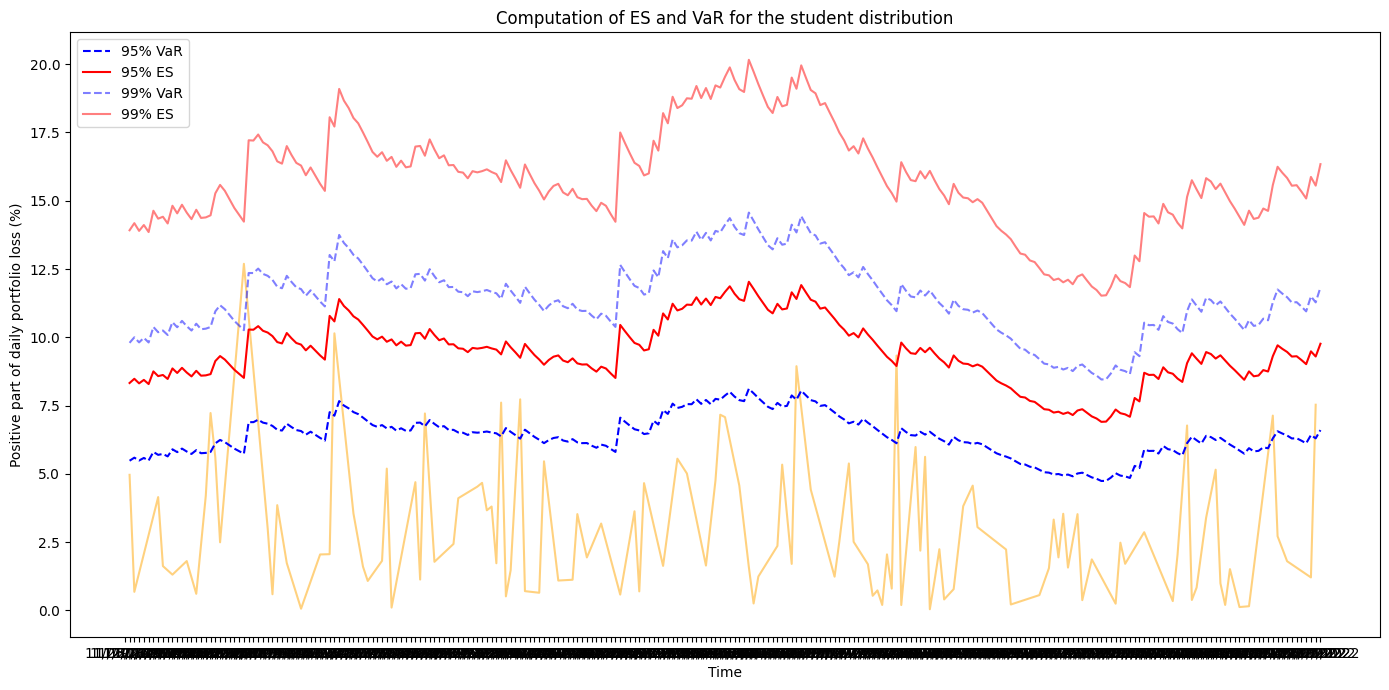

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))

# Actual positive losses
plt.plot(positive_loss(df_test), color='orange', alpha=0.5)

# HS VaR and ES for 95% confidence level
plt.plot(df_test['Date'], df_test.VaR_95_student, label='95% VaR', linestyle='--', color='blue')
plt.plot(df_test['Date'], df_test.ES_95_student, label='95% ES', color='red')

# HS VaR and ES for 99% confidence level
plt.plot(df_test['Date'], df_test.VaR_99_student, label='99% VaR', linestyle='--', color='blue', alpha=0.5)
plt.plot(df_test['Date'], df_test.ES_99_student, label='99% ES', color='red', alpha=0.5)

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Positive part of daily portfolio loss (%)')
plt.title('Computation of ES and VaR for the student distribution')
plt.legend(loc='upper left')

# Turn off the grid
plt.grid(False)

plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [ ]:

print(p_value_LRUC_student(df_test,0.95))
print(p_value_LRUC_student(df_test,0.99))

nb violations : 11
0.6468496471131203
nb violations : 1
0.27561379392120733


### C) GPD

VaR and ES Calculation for GPD (Generalized Pareto Distribution):

**VaR Calculation:**
VaR for GPD is given by the formula:
\[ \text{VaR}_{\alpha} = u + \frac{\sigma}{\xi} \left[ \left(\frac{q}{\alpha}\right)^{-\xi} - 1 \right] \]

where \( u \) is the threshold, \( \sigma \) is the scale parameter, \( \xi \) is the shape parameter, \( q \) is the quantile of the GPD distribution.

**ES Calculation:**
Expected Shortfall for GPD is given by:
\[ \text{ES}_{\alpha} = \frac{\text{VaR}_{\alpha} + \sigma}{1 - \xi} \]

In [ ]:
print(xi_estimate)
print(beta_estimate)

0.01
1.2099844163525872


In [ ]:
def quantile_pareto(p, xi, beta, u):
    """
    Calculate the quantile of the Pareto distribution.

    Parameters:
    - p (float): Probability value (0 < p < 1).
    - xi (float): Shape parameter.
    - beta (float): Scale parameter.
    - u (float): Threshold value.

    Returns:
    float: Quantile of the Pareto distribution.
    """
    if p <= 0 or p >= 1:
        raise ValueError("Probability value must be in the range (0, 1).")

    if xi <= 0 or beta <= 0 or u <= 0:
        raise ValueError("Shape, scale, and threshold parameters must be positive.")

    quantile = u / (math.pow(1 - p, 1 / xi))
    return quantile


def ES_pareto(alpha : float, u :float, ksi : float, beta : float):
    return quantile_pareto(alpha,u,ksi,beta)/(1-ksi) + (beta - ksi * u)/(1-ksi)


In [ ]:
import math
q95 = quantile_pareto(0.95,u,xi_estimate,beta_estimate)
q99 = quantile_pareto(0.99,u,xi_estimate,beta_estimate)


for i in range(1,len(df_test)):
    df_test.loc[i,'VaR_95_pareto']=mu+df_test.loc[i,'sigma']*q95
    df_test.loc[i,'VaR_99_pareto']=mu+df_test.loc[i,'sigma']*q99
    df_test.loc[i,'ES_95_pareto']=mu+df_test.loc[i,'sigma']*ES_95
    df_test.loc[i,'ES_99_pareto']=mu+df_test.loc[i,'sigma']*ES_99

<ipython-input-438-c6b17bb1377a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[i,'VaR_95_pareto']=mu+df_test.loc[i,'sigma']*q95
<ipython-input-438-c6b17bb1377a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[i,'VaR_99_pareto']=mu+df_test.loc[i,'sigma']*q99
<ipython-input-438-c6b17bb1377a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [ ]:
def pi_estimator_pareto(data_bis:pd.DataFrame, alpha:float):
    data = data_bis.dropna()
    if alpha==0.95:
        return len(data.loc[data.logreturn>data.VaR_95_pareto])/len(data)
    elif alpha==0.99:
        return len(data.loc[data.logreturn>data.VaR_99_pareto])/len(data)

def LRUC_pareto(data_bis:pd.DataFrame, alpha:float):
    data = data_bis.dropna()
    data.reset_index(inplace=True,drop=True)
    pi = pi_estimator(data,alpha)
    if alpha ==0.95:
        n=len(data.loc[data.logreturn > data.VaR_95_pareto])
    else:
        n=len(data.loc[data.logreturn > data.VaR_99_pareto])
    print('nb violations :',n)
    return -2*n*np.log((1-alpha)/pi) - 2 * (len(data)-n) * np.log(alpha/(1-pi))


def p_value_LRUC_pareto(data:pd.DataFrame, alpha:float):
    return 1-chi2.cdf(LRUC_pareto(data, alpha),1)

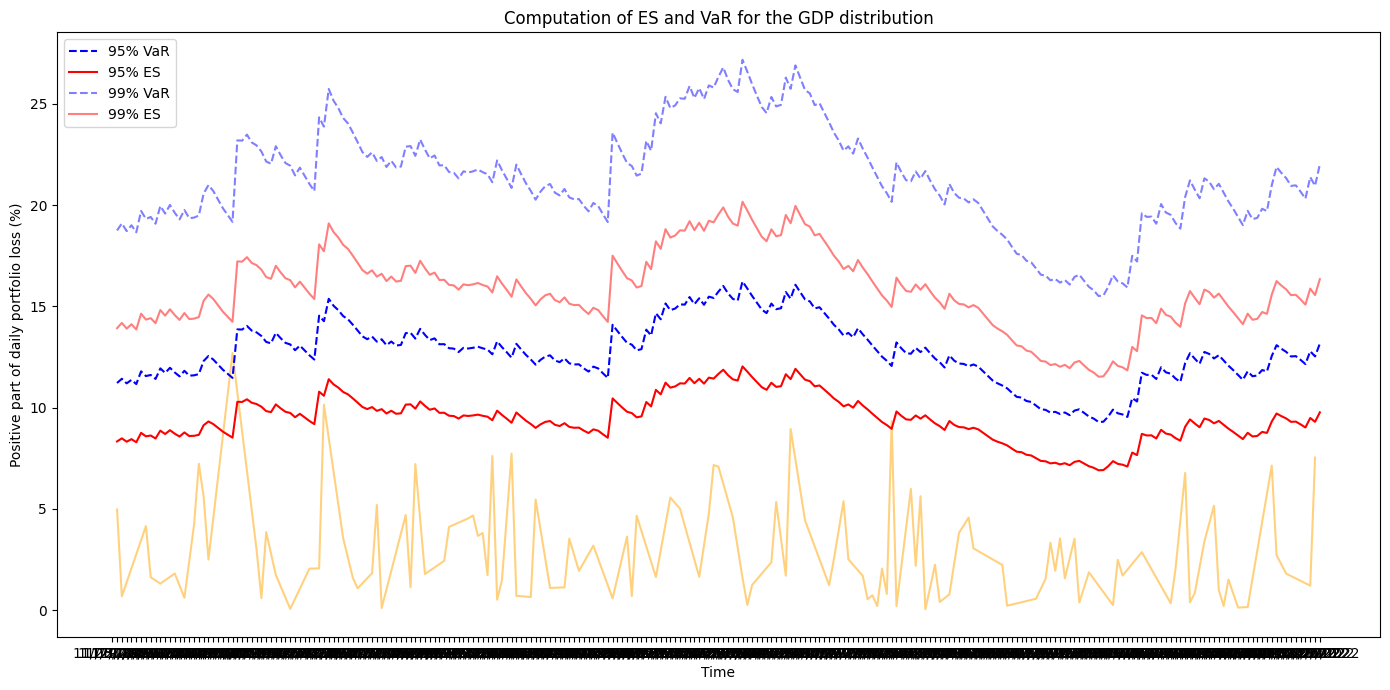

In [ ]:
# Plotting
plt.figure(figsize=(14, 7))

# Actual positive losses
plt.plot(positive_loss(df_test), color='orange', alpha=0.5)

# HS VaR and ES for 95% confidence level
plt.plot(df_test['Date'], df_test.VaR_95_pareto, label='95% VaR', linestyle='--', color='blue')
plt.plot(df_test['Date'], df_test.ES_95_pareto, label='95% ES', color='red')

# HS VaR and ES for 99% confidence level
plt.plot(df_test['Date'], df_test.VaR_99_pareto, label='99% VaR', linestyle='--', color='blue', alpha=0.5)
plt.plot(df_test['Date'], df_test.ES_99_pareto, label='99% ES', color='red', alpha=0.5)

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Positive part of daily portfolio loss (%)')
plt.title('Computation of ES and VaR for the GDP distribution')
plt.legend(loc='upper left')

# Turn off the grid
plt.grid(False)

plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

In [ ]:
print(p_value_LRUC_pareto(df_test,0.95))
print(p_value_LRUC_pareto(df_test,0.99))

nb violations : 1
0.08450848623916563
nb violations : 0
0.31033554912636063
